In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.layers import Input,Conv2D, Dropout, Flatten, Dense, Reshape, Conv2DTranspose, ReLU, BatchNormalization,LeakyReLU 
from visual import save_gan, cvt_gif
from utils import set_soft_gpu, binary_accuracy, save_weights
import time

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6



# 資料集讀取

In [3]:
train_dir = "./100k_black"
batch_size = 4096
def preprocessingDataSet(image):
    image = (image.astype(np.float32))/ 255. * 2 - 1
    return image
train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessingDataSet)

train_generator = train_datagen.flow_from_directory(
 train_dir,
 target_size=(24,24),
 batch_size=batch_size,
 class_mode=None,
 color_mode="grayscale"
)

Found 100000 images belonging to 1 classes.


# Model

In [4]:
class dcgan(keras.Model):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.img_shape = img_shape
        
        self.g = self._get_generator()
        self.d = self._get_discriminator()
        
        self.opt = keras.optimizers.Adam(0.0002, beta_1=0.5)
        self.loss_func = keras.losses.BinaryCrossentropy(from_logits=True)
        
    def call(self, n, training=None, mask=None):
        return self.g.call(tf.random.normal((n, self.latent_dim)), training=training)

    def _get_generator(self):
        model = keras.Sequential(name="generator")
        # [n, 100] -> [n, 6 * 6 * 128] -> [n, 6, 6, 128]
        model.add(Input( shape=self.latent_dim ) )
        model.add(Dense(6 * 6 * 128))
        
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Reshape((6, 6, 128)))
        # -> [n, 12, 12, 64]
        model.add(Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
        # -> [n, 24, 24, 32]
        model.add(Conv2DTranspose(32, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
        # -> [n, 24, 24, 1]
        model.add(Conv2D(1, (4, 4), padding='same', activation=keras.activations.tanh))
        
        model.summary()
        return model
    def _get_discriminator(self):
        model = keras.Sequential(name="discriminator")
        model.add(Input( shape=self.img_shape ) )
        model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
        
        model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(1))
        model.summary()
        return model
    
    def train_d(self, img, label):
        with tf.GradientTape() as tape:
            pred = self.d.call(img, training=True)
            loss = self.loss_func(label, pred)
        grads = tape.gradient(loss, self.d.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.d.trainable_variables))
        return loss, binary_accuracy(label, pred)
    def train_g(self, d_label):
        with tf.GradientTape() as tape:
            g_img = self.call(len(d_label), training=True)
            pred = self.d.call(g_img, training=False)
            loss = self.loss_func(d_label, pred)
        grads = tape.gradient(loss, self.g.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.g.trainable_variables))
        return loss, g_img, binary_accuracy(d_label, pred)
    
    def step(self, img):
        d_label = tf.ones((len(img) * 2, 1), tf.float32)  # let d think generated images are real
        g_loss, g_img, g_acc = self.train_g(d_label)
        d_label = tf.concat((tf.ones((len(img), 1), tf.float32), tf.zeros((len(g_img)//2, 1), tf.float32)), axis=0)
        img = tf.concat((img, g_img[:len(g_img)//2]), axis=0)
        d_loss, d_acc = self.train_d(img, d_label)
        return d_loss, d_acc, g_loss, g_acc
def train(gan, epoch,steps_per_epoch):
    t0 = time.time()
    for ep in range(epoch):
        for i in range(steps_per_epoch):
            d_loss, d_acc, g_loss, g_acc = gan.step(train_generator.next())
            if i % steps_per_epoch-1 == 0:
                t1 = time.time()
                print(
                    "ep={} | time={:.1f} | t={} | d_acc={:.2f} | g_acc={:.2f} | d_loss={:.2f} | g_loss={:.2f}".format(
                        ep, t1 - t0, i, d_acc.numpy(), g_acc.numpy(), d_loss.numpy(), g_loss.numpy(), ))
                t0 = t1
        if(ep%10==0):
            gan.g.save('./model/{}epochs.h5'.format(ep))
        save_gan(gan, ep)
    save_weights(gan)
    cvt_gif(gan)
    

In [5]:
letentDim = 100
imgShape = (24, 24, 1)
epochs = 500
steps_per_epoch = 25
model = dcgan(letentDim, imgShape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4608)              465408    
                                                                 
 batch_normalization (BatchN  (None, 4608)             18432     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 4608)              0         
                                                                 
 reshape (Reshape)           (None, 6, 6, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 64)       131136    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 64)       2

In [6]:
train(model, epochs ,steps_per_epoch)

ep=0 | time=9.3 | t=1 | d_acc=0.50 | g_acc=0.00 | d_loss=0.67 | g_loss=0.69
ep=1 | time=31.2 | t=1 | d_acc=1.00 | g_acc=0.00 | d_loss=0.39 | g_loss=0.65
ep=2 | time=29.0 | t=1 | d_acc=0.62 | g_acc=0.00 | d_loss=0.54 | g_loss=0.92
ep=3 | time=29.9 | t=1 | d_acc=0.81 | g_acc=0.00 | d_loss=0.51 | g_loss=0.85
ep=4 | time=29.5 | t=1 | d_acc=0.79 | g_acc=0.00 | d_loss=0.48 | g_loss=0.95
ep=5 | time=29.0 | t=1 | d_acc=0.78 | g_acc=0.00 | d_loss=0.50 | g_loss=0.90
ep=6 | time=29.2 | t=1 | d_acc=0.72 | g_acc=0.00 | d_loss=0.51 | g_loss=0.99
ep=7 | time=29.2 | t=1 | d_acc=0.77 | g_acc=0.00 | d_loss=0.53 | g_loss=0.85
ep=8 | time=29.2 | t=1 | d_acc=0.64 | g_acc=0.00 | d_loss=0.60 | g_loss=0.86
ep=9 | time=29.4 | t=1 | d_acc=0.66 | g_acc=0.00 | d_loss=0.60 | g_loss=0.82
ep=10 | time=29.4 | t=1 | d_acc=0.67 | g_acc=0.01 | d_loss=0.63 | g_loss=0.80
ep=11 | time=29.2 | t=1 | d_acc=0.69 | g_acc=0.08 | d_loss=0.58 | g_loss=0.83
ep=12 | time=29.2 | t=1 | d_acc=0.62 | g_acc=0.02 | d_loss=0.59 | g_loss=0.

ep=86 | time=29.4 | t=1 | d_acc=0.97 | g_acc=0.02 | d_loss=0.45 | g_loss=0.81
ep=87 | time=29.4 | t=1 | d_acc=0.66 | g_acc=0.00 | d_loss=0.44 | g_loss=1.45
ep=88 | time=29.4 | t=1 | d_acc=0.97 | g_acc=0.02 | d_loss=0.44 | g_loss=0.84
ep=89 | time=29.2 | t=1 | d_acc=0.66 | g_acc=0.00 | d_loss=0.43 | g_loss=1.46
ep=90 | time=29.4 | t=1 | d_acc=0.93 | g_acc=0.01 | d_loss=0.43 | g_loss=0.94
ep=91 | time=29.4 | t=1 | d_acc=0.67 | g_acc=0.00 | d_loss=0.43 | g_loss=1.42
ep=92 | time=29.4 | t=1 | d_acc=0.92 | g_acc=0.01 | d_loss=0.41 | g_loss=0.98
ep=93 | time=29.4 | t=1 | d_acc=0.89 | g_acc=0.00 | d_loss=0.41 | g_loss=1.04
ep=94 | time=29.4 | t=1 | d_acc=0.96 | g_acc=0.02 | d_loss=0.43 | g_loss=0.89
ep=95 | time=29.6 | t=1 | d_acc=0.68 | g_acc=0.00 | d_loss=0.42 | g_loss=1.41
ep=96 | time=29.5 | t=1 | d_acc=0.97 | g_acc=0.02 | d_loss=0.43 | g_loss=0.89
ep=97 | time=29.4 | t=1 | d_acc=0.67 | g_acc=0.00 | d_loss=0.42 | g_loss=1.44
ep=98 | time=29.4 | t=1 | d_acc=0.94 | g_acc=0.01 | d_loss=0.42 

ep=171 | time=30.2 | t=1 | d_acc=0.97 | g_acc=0.06 | d_loss=0.36 | g_loss=0.99
ep=172 | time=30.0 | t=1 | d_acc=0.77 | g_acc=0.00 | d_loss=0.33 | g_loss=1.82
ep=173 | time=30.0 | t=1 | d_acc=0.98 | g_acc=0.02 | d_loss=0.34 | g_loss=1.12
ep=174 | time=30.0 | t=1 | d_acc=0.87 | g_acc=0.00 | d_loss=0.31 | g_loss=1.57
ep=175 | time=30.1 | t=1 | d_acc=0.96 | g_acc=0.01 | d_loss=0.31 | g_loss=1.35
ep=176 | time=30.0 | t=1 | d_acc=0.80 | g_acc=0.00 | d_loss=0.32 | g_loss=1.75
ep=177 | time=30.0 | t=1 | d_acc=0.97 | g_acc=0.01 | d_loss=0.32 | g_loss=1.23
ep=178 | time=30.0 | t=1 | d_acc=0.94 | g_acc=0.00 | d_loss=0.30 | g_loss=1.46
ep=179 | time=30.0 | t=1 | d_acc=0.82 | g_acc=0.00 | d_loss=0.31 | g_loss=1.73
ep=180 | time=30.0 | t=1 | d_acc=0.92 | g_acc=0.00 | d_loss=0.31 | g_loss=1.46
ep=181 | time=30.1 | t=1 | d_acc=0.67 | g_acc=0.00 | d_loss=0.37 | g_loss=2.24
ep=182 | time=30.0 | t=1 | d_acc=0.98 | g_acc=0.02 | d_loss=0.31 | g_loss=1.20
ep=183 | time=30.0 | t=1 | d_acc=0.74 | g_acc=0.00 |

ep=258 | time=30.4 | t=1 | d_acc=0.98 | g_acc=0.03 | d_loss=0.27 | g_loss=1.35
ep=259 | time=30.4 | t=1 | d_acc=0.98 | g_acc=0.02 | d_loss=0.26 | g_loss=1.43
ep=260 | time=30.2 | t=1 | d_acc=0.87 | g_acc=0.00 | d_loss=0.25 | g_loss=2.15
ep=261 | time=30.6 | t=1 | d_acc=0.97 | g_acc=0.00 | d_loss=0.23 | g_loss=1.77
ep=262 | time=31.2 | t=1 | d_acc=0.98 | g_acc=0.01 | d_loss=0.25 | g_loss=1.51
ep=263 | time=30.8 | t=1 | d_acc=0.83 | g_acc=0.00 | d_loss=0.26 | g_loss=2.29
ep=264 | time=30.2 | t=1 | d_acc=0.98 | g_acc=0.01 | d_loss=0.24 | g_loss=1.57
ep=265 | time=30.3 | t=1 | d_acc=0.78 | g_acc=0.00 | d_loss=0.28 | g_loss=2.44
ep=266 | time=30.5 | t=1 | d_acc=0.85 | g_acc=0.00 | d_loss=0.25 | g_loss=2.24
ep=267 | time=30.4 | t=1 | d_acc=0.98 | g_acc=0.03 | d_loss=0.27 | g_loss=1.35
ep=268 | time=30.3 | t=1 | d_acc=0.80 | g_acc=0.00 | d_loss=0.28 | g_loss=2.37
ep=269 | time=30.4 | t=1 | d_acc=0.79 | g_acc=0.00 | d_loss=0.27 | g_loss=2.49
ep=270 | time=30.4 | t=1 | d_acc=0.85 | g_acc=0.00 |

ep=343 | time=30.6 | t=1 | d_acc=0.98 | g_acc=0.04 | d_loss=0.25 | g_loss=1.43
ep=344 | time=30.7 | t=1 | d_acc=0.89 | g_acc=0.00 | d_loss=0.21 | g_loss=2.51
ep=345 | time=30.8 | t=1 | d_acc=0.97 | g_acc=0.00 | d_loss=0.21 | g_loss=1.98
ep=346 | time=30.4 | t=1 | d_acc=0.83 | g_acc=0.00 | d_loss=0.24 | g_loss=2.72
ep=347 | time=30.6 | t=1 | d_acc=0.97 | g_acc=0.07 | d_loss=0.27 | g_loss=1.38
ep=348 | time=30.6 | t=1 | d_acc=0.99 | g_acc=0.02 | d_loss=0.22 | g_loss=1.72
ep=349 | time=30.8 | t=1 | d_acc=0.87 | g_acc=0.00 | d_loss=0.22 | g_loss=2.53
ep=350 | time=30.6 | t=1 | d_acc=0.85 | g_acc=0.00 | d_loss=0.23 | g_loss=2.66
ep=351 | time=30.8 | t=1 | d_acc=0.98 | g_acc=0.04 | d_loss=0.25 | g_loss=1.47
ep=352 | time=30.6 | t=1 | d_acc=0.76 | g_acc=0.00 | d_loss=0.30 | g_loss=3.12
ep=353 | time=30.6 | t=1 | d_acc=0.90 | g_acc=0.00 | d_loss=0.21 | g_loss=2.44
ep=354 | time=30.8 | t=1 | d_acc=0.98 | g_acc=0.01 | d_loss=0.21 | g_loss=1.85
ep=355 | time=30.8 | t=1 | d_acc=0.81 | g_acc=0.00 |

ep=430 | time=31.2 | t=1 | d_acc=0.97 | g_acc=0.05 | d_loss=0.23 | g_loss=1.58
ep=431 | time=31.0 | t=1 | d_acc=0.77 | g_acc=0.00 | d_loss=0.29 | g_loss=3.50
ep=432 | time=31.2 | t=1 | d_acc=0.98 | g_acc=0.01 | d_loss=0.18 | g_loss=2.09
ep=433 | time=31.2 | t=1 | d_acc=0.93 | g_acc=0.00 | d_loss=0.18 | g_loss=2.57
ep=434 | time=31.2 | t=1 | d_acc=0.98 | g_acc=0.01 | d_loss=0.18 | g_loss=2.06
ep=435 | time=31.1 | t=1 | d_acc=0.90 | g_acc=0.00 | d_loss=0.19 | g_loss=2.77
ep=436 | time=30.9 | t=1 | d_acc=0.98 | g_acc=0.02 | d_loss=0.19 | g_loss=1.93
ep=437 | time=31.1 | t=1 | d_acc=0.91 | g_acc=0.00 | d_loss=0.18 | g_loss=2.76
ep=438 | time=31.0 | t=1 | d_acc=0.97 | g_acc=0.07 | d_loss=0.25 | g_loss=1.44
ep=439 | time=31.2 | t=1 | d_acc=0.98 | g_acc=0.02 | d_loss=0.19 | g_loss=1.90
ep=440 | time=31.0 | t=1 | d_acc=0.89 | g_acc=0.00 | d_loss=0.19 | g_loss=2.85
ep=441 | time=31.2 | t=1 | d_acc=0.98 | g_acc=0.01 | d_loss=0.17 | g_loss=2.19
ep=442 | time=31.2 | t=1 | d_acc=0.92 | g_acc=0.00 |

<Figure size 640x480 with 0 Axes>

In [10]:
a = train_generator.next()
a.shape

(2048, 24, 24, 1)

In [7]:
import matplotlib.pyplot as plt
import cv2

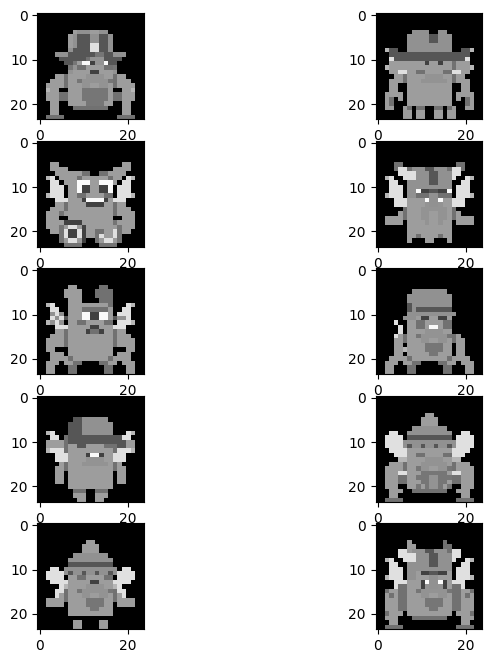

In [8]:
count = 1 
plt.figure(num='img',figsize=(8,8))
for i in range(10):
    
    a = train_generator.next()
    img = a[0].reshape(24,24,1)
    img = (img+1)/2*255
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype('int')
    plt.subplot(5,2,i+1)
    plt.imshow(img)
    
    count+=1
plt.show()

In [5]:
a = train_generator.next()
a

array([[[[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        [[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        [[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        ...,

        [[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        [[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]],

        [[-1.       ],
         [-1.       ],
         [-1.       ],
         ...,
         [-1.       ],
         [-1.       ],
         [-1.       ]]],


       [[[-1.       ],
         [-1.       ],
         [-1. 